# Предварительная работа с каждым каналом изображения для последующей сегментации: нормализация/эквализация гистограммы, фильтрация шумов

In [1]:
from load_imgs_from_folder import *
imgs_names, imgs = load_images_from_folder(r'tiled_data', ['Stitched_cropped'], '*.tif')

# Фильтрация от шумов (медианная и гаусова)

In [21]:
# Адаптивная медианная фильтрация
from adaptive_median_filter import *
imgs_median_filtered = imgs.copy()
for i, img in enumerate(imgs_median_filtered):
    imgs_median_filtered[i] = adaptive_median_filter(img)

2387025 pixel(s) filtered out of 2396304
2387025 pixel(s) filtered out of 2396304
2387025 pixel(s) filtered out of 2396304
2387025 pixel(s) filtered out of 2396304
2387025 pixel(s) filtered out of 2396304


In [22]:
# Гауссова фильтрация
import scipy.ndimage
imgs_medgauss_filtered = imgs.copy()
for i, img in enumerate(imgs_medgauss_filtered):
    imgs_medgauss_filtered[i] = scipy.ndimage.gaussian_filter(img, sigma=1)

Populating the interactive namespace from numpy and matplotlib


C:\Users\denni\Anaconda3\lib\site-packages\IPython\core\magics\pylab.py:160: UserWarning: pylab import has clobbered these variables: ['axes', 'f']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


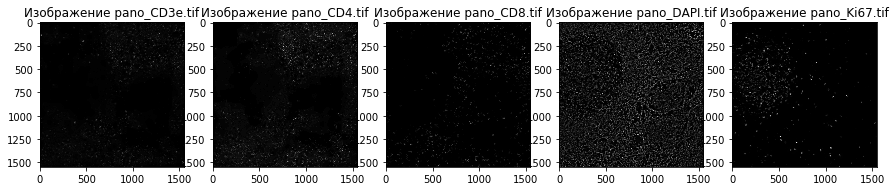

In [23]:
%pylab inline
import matplotlib.pyplot as plt
f, axes = plt.subplots(1, len(imgs_names), figsize = (15, 15))
for i in range(len(imgs_names)):
    axes[i].imshow(imgs_medgauss_filtered[i], cmap='gray')
    axes[i].set_title("Изображение " + imgs_names[i])

# Отображение изображений и соответствующих им гистограмм

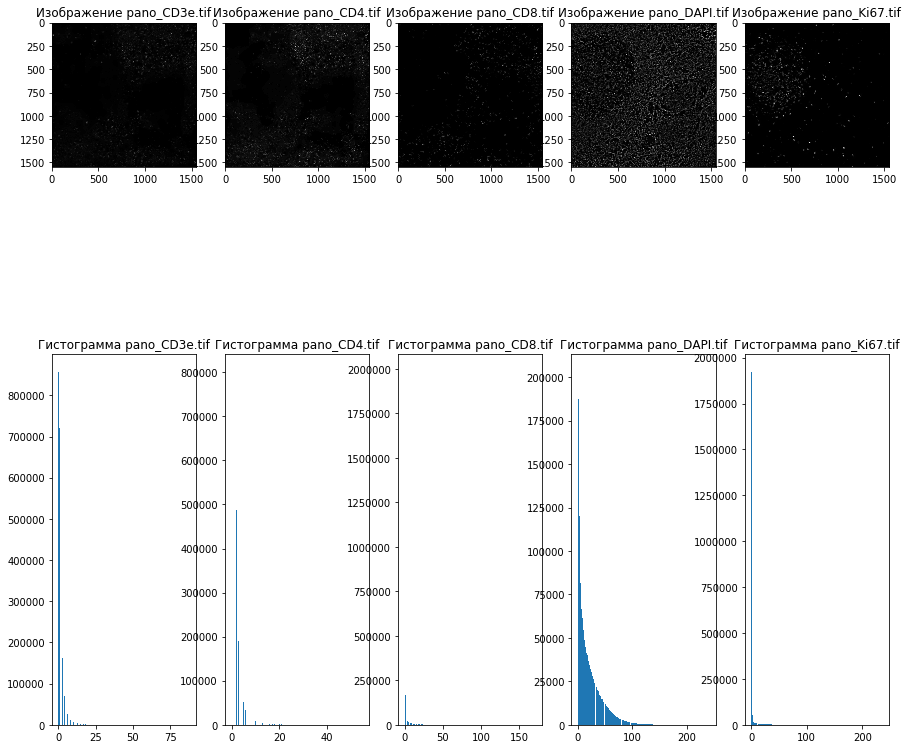

In [24]:
import matplotlib.pyplot as plt
f, axes = plt.subplots(2, len(imgs_names), figsize = (15, 15))
for i in range(len(imgs_names)):
    axes[0, i % len(imgs_names)].imshow(imgs_medgauss_filtered[i], cmap='gray')
    axes[0, i % len(imgs_names)].set_title("Изображение " + imgs_names[i])
    axes[1, i % len(imgs_names)].hist(imgs_medgauss_filtered[i].flatten(), bins=256)
    axes[1, i % len(imgs_names)].set_title("Гистограмма " + imgs_names[i])

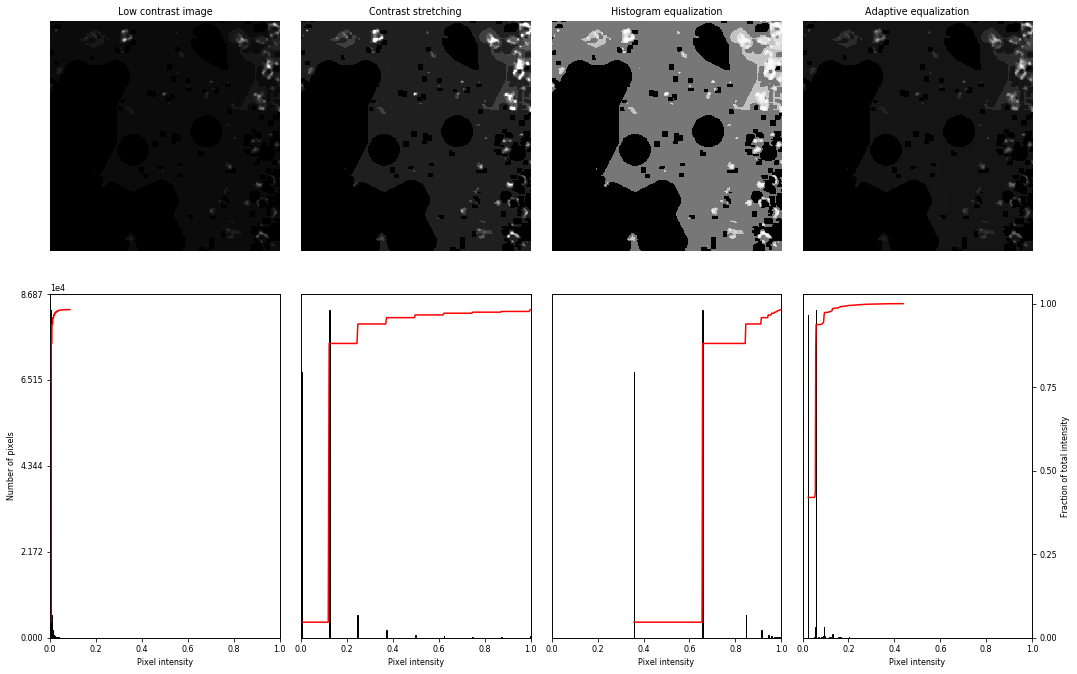

In [25]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np

from skimage import data, img_as_float
from skimage import exposure


matplotlib.rcParams['font.size'] = 8


def plot_img_and_hist(image, axes, bins=256):
    """Plot an image along with its histogram and cumulative histogram.

    """
    image = img_as_float(image)
    ax_img, ax_hist = axes
    ax_cdf = ax_hist.twinx()

    # Display image
    ax_img.imshow(image, cmap=plt.cm.gray)
    ax_img.set_axis_off()

    # Display histogram
    ax_hist.hist(image.ravel(), bins=bins, histtype='step', color='black')
    ax_hist.ticklabel_format(axis='y', style='scientific', scilimits=(0, 0))
    ax_hist.set_xlabel('Pixel intensity')
    ax_hist.set_xlim(0, 1)
    ax_hist.set_yticks([])

    # Display cumulative distribution
    img_cdf, bins = exposure.cumulative_distribution(image, bins)
    ax_cdf.plot(bins, img_cdf, 'r')
    ax_cdf.set_yticks([])

    return ax_img, ax_hist, ax_cdf


# Load an example image
img = imgs_medgauss_filtered[0]

# Contrast stretching
p2, p98 = np.percentile(img, (2, 98))
img_rescale = exposure.rescale_intensity(img, in_range=(p2, p98))

# Equalization
img_eq = exposure.equalize_hist(img)

# Adaptive Equalization
img_adapteq = exposure.equalize_adapthist(img, clip_limit=0.03)

# Display results
fig = plt.figure(figsize=(15, 10))
axes = np.zeros((2, 4), dtype=np.object)
axes[0, 0] = fig.add_subplot(2, 4, 1)
for i in range(1, 4):
    axes[0, i] = fig.add_subplot(2, 4, 1+i, sharex=axes[0,0], sharey=axes[0,0])
for i in range(0, 4):
    axes[1, i] = fig.add_subplot(2, 4, 5+i)

ax_img, ax_hist, ax_cdf = plot_img_and_hist(img[400:800, 400:800], axes[:, 0])
ax_img.set_title('Low contrast image')

y_min, y_max = ax_hist.get_ylim()
ax_hist.set_ylabel('Number of pixels')
ax_hist.set_yticks(np.linspace(0, y_max, 5))

ax_img, ax_hist, ax_cdf = plot_img_and_hist(img_rescale[400:800, 400:800], axes[:, 1])
ax_img.set_title('Contrast stretching')

ax_img, ax_hist, ax_cdf = plot_img_and_hist(img_eq[400:800, 400:800], axes[:, 2])
ax_img.set_title('Histogram equalization')

ax_img, ax_hist, ax_cdf = plot_img_and_hist(img_adapteq[400:800, 400:800], axes[:, 3])
ax_img.set_title('Adaptive equalization')

ax_cdf.set_ylabel('Fraction of total intensity')
ax_cdf.set_yticks(np.linspace(0, 1, 5))

# prevent overlap of y-axis labels
fig.tight_layout()
plt.show()

## Применение ко всем изображениям адаптивной эквализации
Визуально во всех каналах приводит к повышению контраста объектов и наименьшему изменению однородности фона, при этом не происходит зашкаливания интенсивности.

In [26]:
imgs_eq = imgs_medgauss_filtered.copy()
for i, img in enumerate(imgs_eq):
    imgs_eq[i] = np.uint8(exposure.equalize_adapthist(img) * 255)

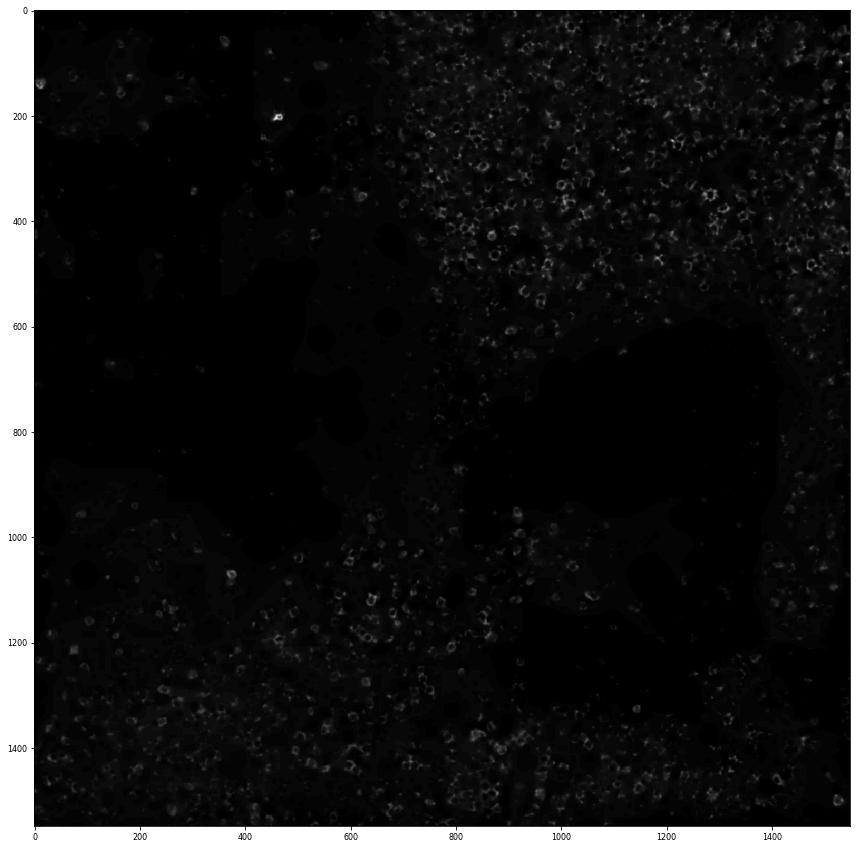

In [27]:
_, ax = plt.subplots(figsize = (15, 15))
ax.imshow(imgs_eq[0], cmap='gray')

In [28]:
# Добавление суммы мебранных маркеров отдельным файлом, предварительно просуммировав
I_membrane = imgs_medgauss_filtered[0] + imgs_medgauss_filtered[1] + imgs_medgauss_filtered[2]
imgs_eq.append(np.uint8(exposure.equalize_adapthist(I_membrane) * 255))
imgs_names.append('pano_Membrane_summary.tif')

In [29]:
# Сохранение предобработанных изображений
from save_imgs_to_folder import *
save_imgs_to_folder(imgs_eq, imgs_names, r"tiled_data\Stitched_cropped_preprocessed")